# Практическое задание №1

Цель работы - решение задач компьютерного зрения в системах управления с использованием предобученных моделей сверточных нейронных сетей из библиотеки PyTorch (см. https://pytorch.org/vision/stable/models.html).

Преимущество предобученных моделей - получение быстрого результата без погружения в детали реализации и выполнения трудоемкого процесса настройки на крупных библиотеках изображений.

Их недостатоки - возможны ограничения лицензий использования как на использованный при обучении набор данных, так и на сами коэффициенты из библиотеки и исходный код модели. Также весовые коэффицпенты расчитываются на публичных библиотеках изображений и зачастую могут оказаться нерелеванты решаемой задаче.

Последнюю проблему обычно решают с помощью набора приемов, известных в англоязычной литературе как "Transfer learning". Суть его состоит в использовании библиотечных коэффициентов и модели как базы для настройки новой модели.

Ниже будет проиллюстрировано решение задач классификации и донастройки модели с использованием библиотеки PyTorch.

## 1. Инициализация преднастроенных нейросетевых моделей

In [26]:
from torchvision import models

alexNet = {
    # https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
    'model': models.alexnet(weights=models.AlexNet_Weights.DEFAULT),
    'weights': models.AlexNet_Weights.DEFAULT,
    'preprocess': models.AlexNet_Weights.DEFAULT.transforms()
}

resNet50 = {
    # https://arxiv.org/abs/1512.03385
    'model': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'weights': models.ResNet50_Weights.DEFAULT,
    'preprocess': models.ResNet50_Weights.DEFAULT.transforms()
}

denseNet = {
    # https://arxiv.org/abs/1608.06993
    'model': models.densenet201(weights=models.DenseNet201_Weights),
    'weights': models.DenseNet201_Weights.DEFAULT,
    'preprocess': models.DenseNet201_Weights.DEFAULT.transforms()
}



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [28]:
for model in [resNet50, alexNet]:
    model['model'].eval()

## Обобщённые функции для классификации изображений и вывода результата

In [29]:
import typing
import matplotlib.pyplot as plt
import torch
import numpy
from torchvision.io import read_image
from requests import get

def classify(model, weights, transformation, image, num_of_classes: int) -> torch.Tensor:
    preprocessed = transformation(image)
    batch = preprocessed.unsqueeze(0)
    result = model(batch).squeeze(0).softmax(0)
    scores = result.cpu().detach().numpy()
    class_list = numpy.flip(scores.argsort())[0:num_of_classes]
    caption = ""
    for class_id in class_list:
        score = result[class_id].item()
        category_name = weights.meta["categories"][class_id]
        caption = f"{caption}\n{category_name}: {100 * score:.1f}%"
    plt.figure()
    plt.imshow(image.permute(1, 2, 0))
    plt.title(caption)
    return result

def process(model, urls: str, num_of_classes: int) -> typing.List[dict]:
    count = 0
    strip_chars = ' \t'
    url_list = [url.strip(strip_chars) for url in urls.splitlines() if len(url.strip(strip_chars)) > 0]
    result = []
    for url in url_list:
        meta = {}
        meta['file'] = str(count)
        meta['url'] = url
        with open(meta['file'], 'wb') as file:
            file.write(get(meta['url']).content)
        meta['image'] = read_image(meta['file'])
        meta['result'] = classify(model['model'], model['weights'], model['preprocess'], meta['image'], num_of_classes)
        result.append(meta)
        ++count
    return result

## Ссылки на изображения для классификации (набор данных)

In [30]:
simple = '''
    https://i03.fotocdn.net/s119/9c4a25d1afe85016/public_pin_l/2730300326.jpg
    https://pp.userapi.com/c639429/v639429799/1b423/EWqrUsA86vo.jpg
    https://cdn1.jigidi.com/thumbs/CTU9QFYI/l
    https://wallbox.ru/resize/320x240/wallpapers/main2/201716/kotenok-seryj.jpg
    http://images4.fanpop.com/image/photos/14700000/So-cute-puppies-14749028-800-600.jpg
    https://calendario.su/wp-content/uploads/2020/03/calendario-con-sfondo-12.jpg
    '''

cnc = '''
    https://fs02.vseosvita.ua/0200otf2-181d.jpg'
    https://st14.stpulscen.ru/images/localized/012/859/486_original.jpg
    https://img.youtube.com/vi/ZaxuckqnMZ0/0.jpg?3489220329
    '''

plant = '''
    https://vpm-parts.ru/800/600/https/konspekta.net/lectmaniaru/baza1/43058697973.files/image017.jpg
    https://prombrand.ru/wp-content/uploads/konveernye-sistemy-soco-system.jpg
    https://avcdn.av.by/wisiwigimage/0000/5926/8164.jpeg
'''

agro = '''
    https://vsegda-pomnim.com/uploads/posts/2022-04/1650639754_84-vsegda-pomnim-com-p-kak-tsvetet-khlorofitum-foto-97.jpg
    https://wallpapersprinted.com/cache/thumbnails/71/97/80/fresh_wheat_field-t1.jpg
    https://img1.goodfon.ru/original/640x480/b/f1/pole-derevo-svet.jpg
    https://img.promportal.su/foto/good_fotos/134/1343535/prodayu-zernouborochniy-kombayn-acros-580-proizvodstva-kompanii-rostselmash_foto_largest.jpg
    https://static.tildacdn.com/tild3938-3165-4637-b639-613531313530/1529410813.jpg
    https://www.claas.de/blueprint/servlet/resource/image/1788044/inline_m_s/400/225/ab80e51c5f27c04b19feaa70e35f574d/BO/332463.jpg
    https://pw.artfile.me/wallpaper/02-07-2015/344x230/tehnika-kombajny-kombajn-pole-zhatva-945905.jpg
    https://17.img.avito.st/640x480/8813699217.jpg
    https://pw.artfile.me/wallpaper/30-05-2018/650x434/tehnika-kombajny-pole-kombajn-1347902.jpg
'''

animals = '''
    https://p0.pikist.com/photos/1011/420/goat-petting-zoo-animal-zoo-domestic-goat-horns-lazing-around-sun-goat-s-head-thumbnail.jpg
    https://banzay.ru/files/4-28-768x513.jpg
    https://i.ytimg.com/vi/eMqIVGGBlps/maxresdefault.jpg
    https://sad-deco.ru/image/cache/catalog/figuri_unikal/sadovaja_figura_korovka-800x800.jpg
    https://woolmerino.ru/wa-data/public/shop/img/ovca_yagnenok_detenysh_mama_sherst_41653_2048x1152-768x4321.jpg
    http://www.hereinuk.com/wp-content/uploads/2016/09/pink-sheep.jpg
    https://i.ytimg.com/vi/GE12O7fdUq8/hqdefault.jpg
    https://tolksnov.ru/assets/i/ai/4/1/1/i/2739788.jpg
'''


## Решение задачи классификации

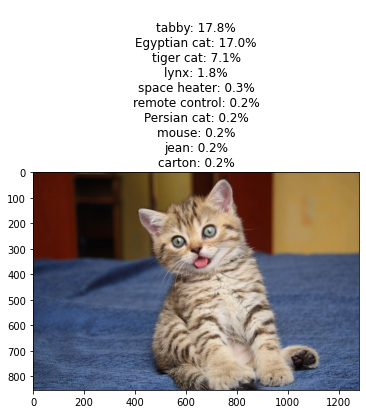

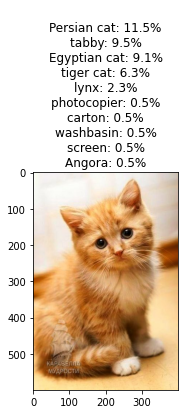

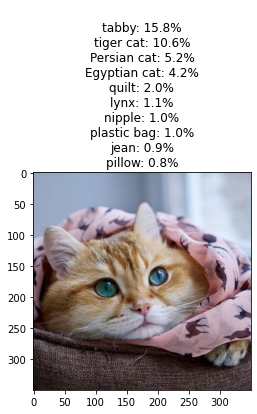

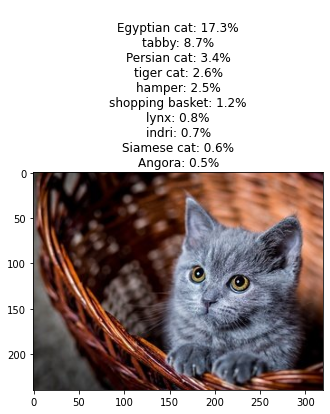

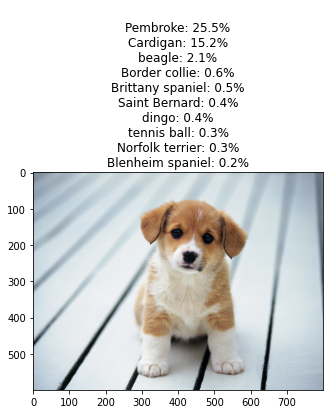

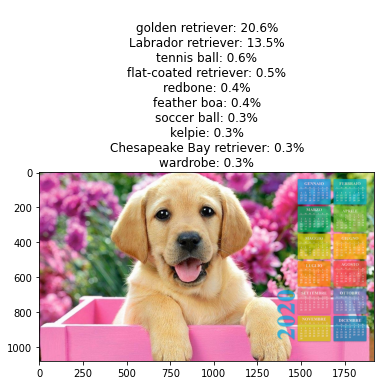

In [33]:
test1 = process(resNet50, simple, 10)

## Задание для самостоятельного исследования
1. В заданной индивидуально категории объектов собрать набор изображений (датасет), который будет обладать следующими характеристиками:
- выбрать 2 целевых объекта для распознавания из заданной категории
- для 50% выборки найти в интернете различные изображения объекта из класса 1
- остальные 50% выборки для второго класса
- использовать различную освещенность объектов (день, ночь, сумерки, на рассвете/закате)
- использовать различный угол взгляда (фронтальная, сбоку, сверху, снизу, в 3/4)
Размер датасета - 100 изображений.

2. Провести классификацию выбранных изображений с использованием преднастроенных коэффициентов для не менее 3х моделей. В отчете привести примеры успешных/неуспешных результатов (12 примеров - по 3 для каждого класса и успешной/неуспешной классификации). Вычислить общую метрику классификации.

3. Провести донастройку модели на собранный датасет и провести классификацию на выбранном наборе данных. Разбить изображения на часть для настройки (80% датасета) и часть для валидации (20% датасета). В отчете привести примеры успешных/неуспешных результатов (12 примеров - по 3 для каждого класса и успешной/неуспешной классификации). Вычислить общую метрику классификации.